<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Stanford-cars/resized/15*15/stanfordcars_15_15_Gabor_Same.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/stanford-cars-128-gray.zip -d stanford-cars-128-gray

In [17]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 195
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
TRAIN_DIR = "stanford-cars-128-gray/stanford-cars-128-gray/train/"
TEST_DIR = "stanford-cars-128-gray/stanford-cars-128-gray/test/"

In [18]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [19]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

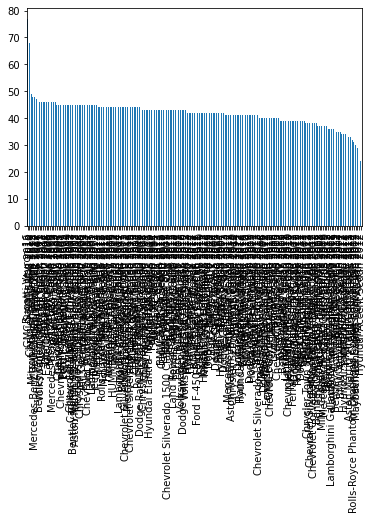

In [20]:
train_df['category'].value_counts().plot.bar()

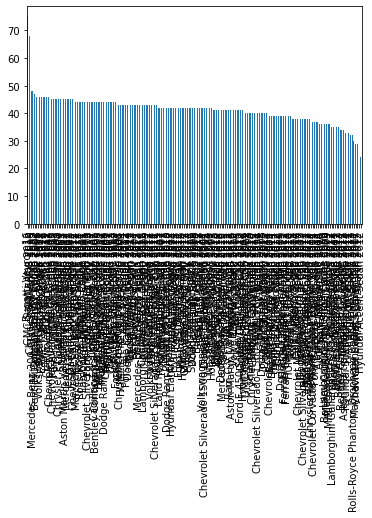

In [21]:
validate_df['category'].value_counts().plot.bar()

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8144 validated image filenames belonging to 195 classes.


In [23]:
validation_datagen = ImageDataGenerator(
    # fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8041 validated image filenames belonging to 195 classes.


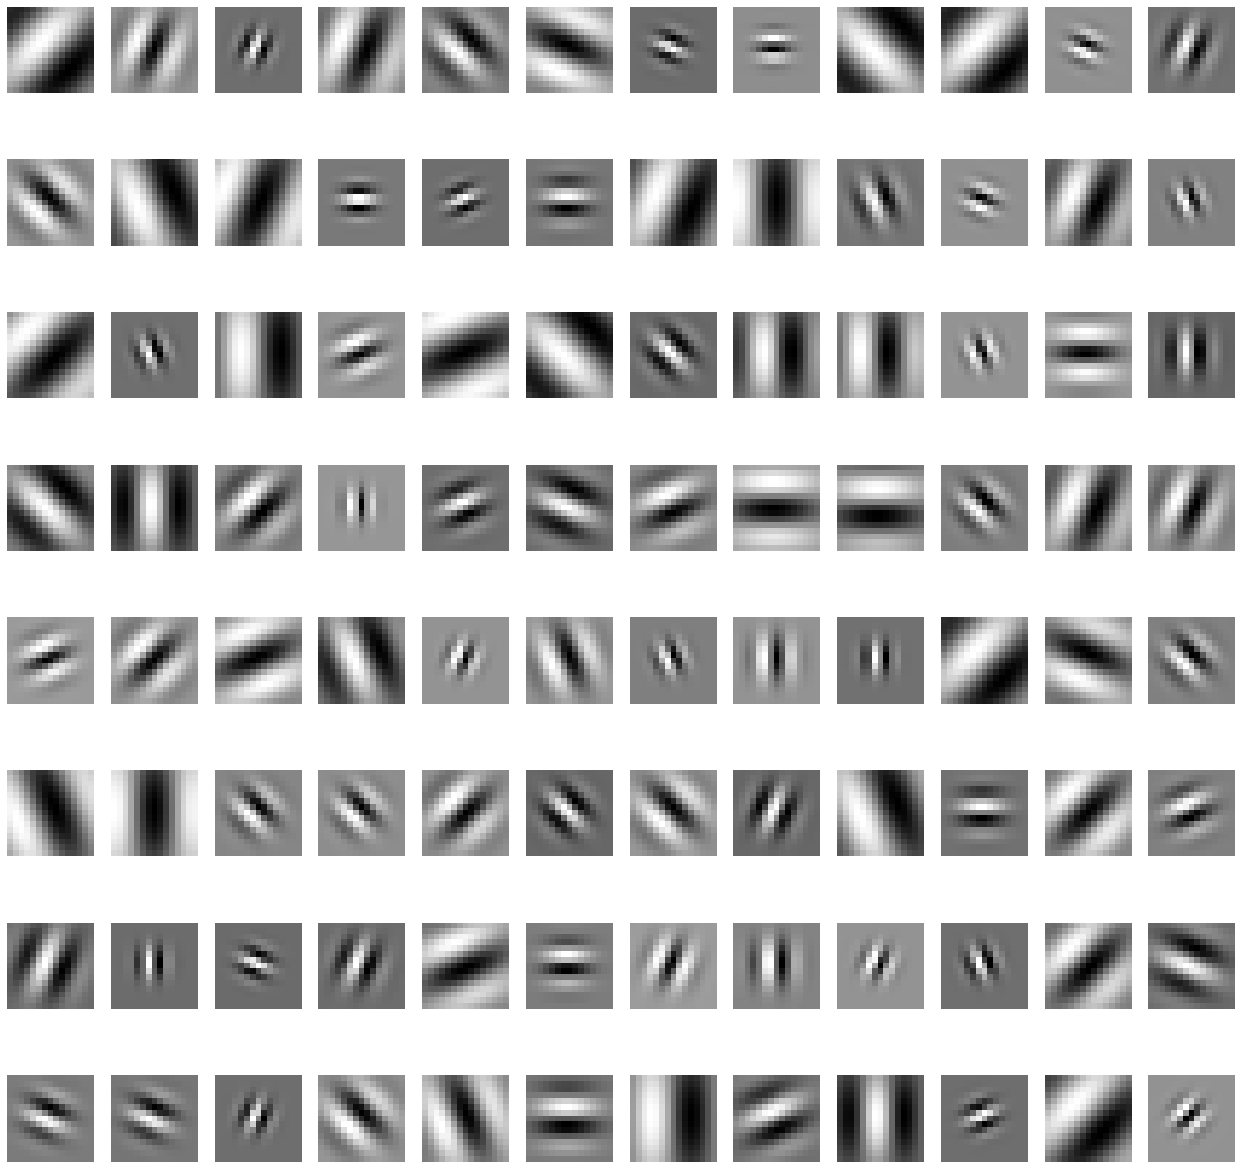

In [24]:
import math

def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*(math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels))))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/(freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
#             g = g / (2 * math.pi * (sigma ** 2))
#             g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, NUM_RECEPTIVE_FILTERS, GABOR_SIZE)

fig = plt.subplots(8, len(filterbank)//8, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [25]:
print(train_df.shape)
print(validate_df.shape)

(8144, 2)
(8041, 2)


In [26]:
train_generator.image_shape

(128, 128, 3)

In [27]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

195


In [28]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', name="GaborLayer", input_shape=train_generator.image_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
        layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GaborLayer (Conv2D)          (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_12 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)       

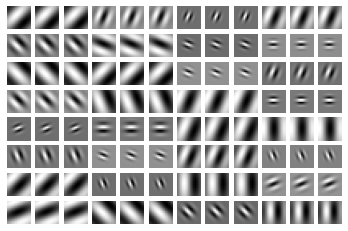

In [29]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape
gabor_filters = W
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index]

classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, len(filter_layers)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig('stanfordcars-{}-initial-gabor-same-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 51s 177ms/step - loss: 5.6027 - accuracy: 0.0057 - auc: 0.5031 - val_loss: 9.2926 - val_accuracy: 0.0075 - val_auc: 0.5086
Epoch 2/1000
178/254 [====================>.........] - ETA: 11s - loss: 5.3754 - accuracy: 0.0066 - auc: 0.5361

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

In [ ]:
import pickle

trained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('stanfordcars-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("stanfordcars-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("stanfordcars-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
!cp stanfordcars-1-initial-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/

In [ ]:
!cp stanfordcars-1-history-gabor-same-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/

In [ ]:
!cp stanfordcars-1-loss-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/

In [ ]:
!cp stanfordcars-1-accuracy-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/

In [ ]:
!cp stanfordcars-1-filters-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/

In [ ]:
!cp stanfordcars-1-channelwise-gabor-same-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-128/1/